In [1]:
import matplotlib as mlt
import matplotlib.pyplot as plt

import numpy as np
import cv2
from Utils import *
from scripts.histeq import equalize_image_histogram

%matplotlib inline
mlt.rcParams['figure.figsize'] = (18,8)

# Histogram equalization

## 0. Loading the images

To illustrate this technique we will work with two example images, one grayscale and one color.
* Grayscale cartoon image from [here](https://stackoverflow.com/questions/48406578/adjusting-contrast-of-image-purely-with-numpy)
* Color tree image from [here](https://freepreset.net/low-contrast-photography-and-how-to-correct-it-in-post-processing.html)



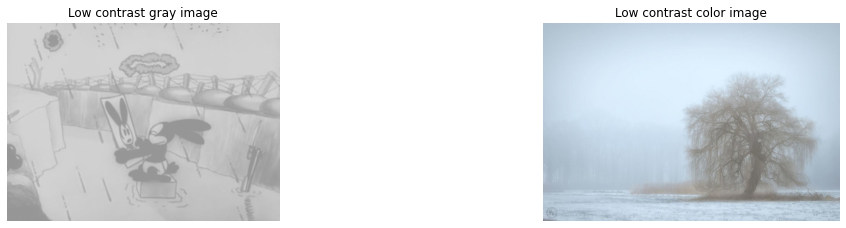

In [2]:
gray_lc_image_path = 'data\low_contrast.png'
gray_lc_image = cv2.imread(gray_lc_image_path, 0)

color_lc_image_path = 'data\low_contrast_color.jpg'
color_lc_image = cv2.imread(color_lc_image_path, 1)
color_lc_image_hsv = cv2.cvtColor(color_lc_image, cv2.COLOR_BGR2HSV)

#Visualize (add vmin=0, vmax=255 to imshow to remove auto scaling of intensity)
# 2,2 grid here to squeeze a bit the image
plt.subplot(2, 2, 1)
plt.title('Low contrast gray image')
plt.imshow(gray_lc_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Low contrast color image')
plt.imshow(np.flip(color_lc_image, axis=2), vmin=0, vmax=255)
plt.axis('off')
plt.show()

## 1. Intensity histogram equalization on the grayscale image

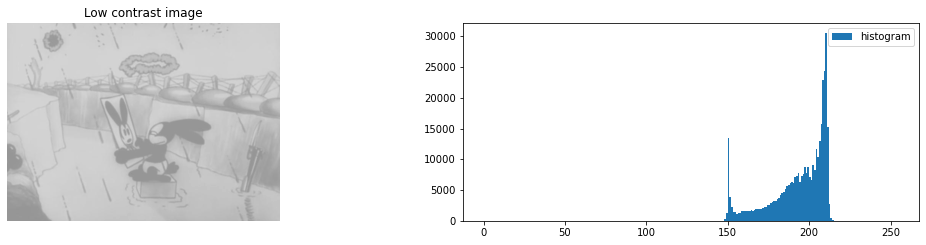

In [3]:
plt.subplot(2, 2, 1)
plt.title('Low contrast image')
plt.imshow(gray_lc_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.hist(gray_lc_image.ravel(), range=(0,255), label='histogram', bins = np.arange(256))
plt.legend()
plt.show()

For a given image $x$, calculate the normalized histogram $p_x(i)$ : 
* For $p$ in $(0,..,L-1)$, $L$ being the number of possible intensity values, $p_x(i) =$ number of pixels with intensity $i$ / total number of pixels
* We obtain a 1D vector of length 256 : x axis = intensity value; y axis = number of pixels of that value

Calculate the normalized cumulative distribution function $cdf_x(i)$:
* For a given intensity value $i$, $cdf_x(i) = \sum_{j=0}^ip_x(i)$
* We obtain a 1D vector of length 256 : x axis = intensity value; y axis = probability of the intensity to be less or equal to that value

The intensity transformation function is defined as follows ([source](https://www.math.uci.edu/icamp/courses/math77c/demos/hist_eq.pdf) taken from the wiki page on histogram equalization) : $T(k)=floor((L-1)*cdf_x(k)$. See implementation in scripts/histeq.py.

In [4]:
# Get original image hisogram and cdf for plotting
gray_lc_image_hist = cv2.calcHist([gray_lc_image],[0],None,[256],[0,256])
gray_lc_image_cdf = np.cumsum(gray_lc_image_hist/gray_lc_image_hist.max())

# Calculate equalized image and get its histogram and cdf for plotting
gray_eq_image = equalize_image_histogram(gray_lc_image)
gray_eq_image_hist = cv2.calcHist([gray_eq_image],[0],None,[256],[0,256])
gray_eq_image_cdf = np.cumsum(gray_eq_image_hist/gray_eq_image_hist.max())

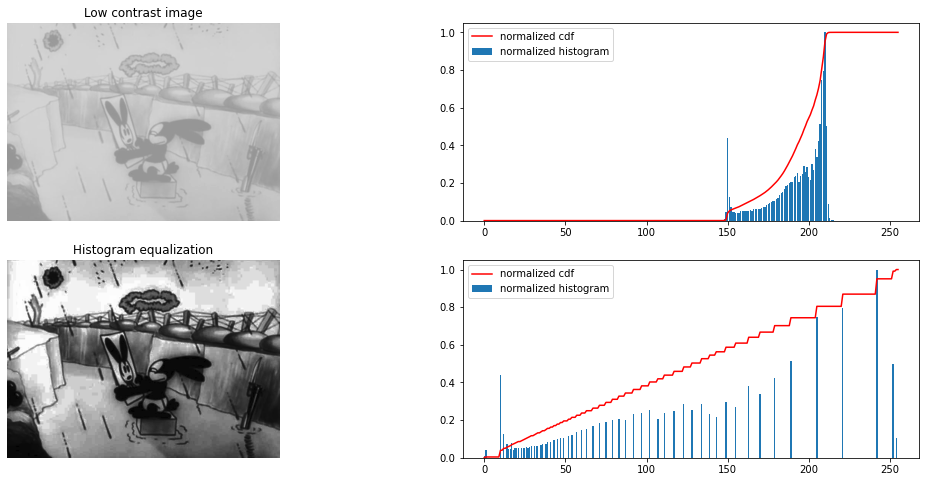

In [5]:
# Visualize
names = ['Low contrast image', 'Histogram equalization']
images = [gray_lc_image, gray_eq_image]
hists = [gray_lc_image_hist, gray_eq_image_hist]
cdfs = [gray_lc_image_cdf, gray_eq_image_cdf]

for i in range(2):
    
    plt.subplot(2, 2, i*2+1)
    plt.title(names[i])
    plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

    plt.subplot(2, 2, i*2+2)
    plt.bar(np.arange(256), hists[i][:,0]/hists[i].max(), label='normalized histogram')
    plt.plot(cdfs[i]/cdfs[i].max(), label='normalized cdf', color = 'r')
    plt.legend()

## 2. Intensity histogram equalization on the color image

### 2.1 What happens if equalize the histograms of the R, G, B channels instead ?

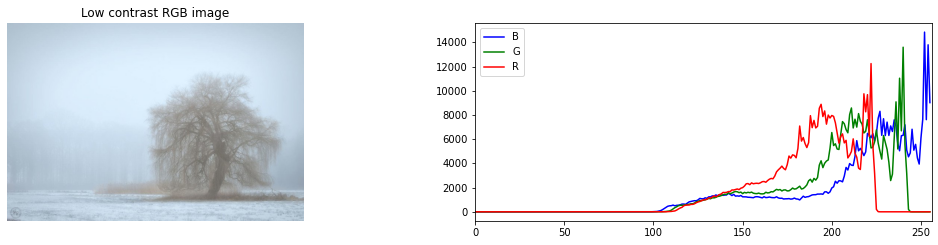

In [6]:
# 2,2 grid here to squeeze a bit the image
plt.subplot(2, 2, 1)
plt.title('Low contrast RGB image')
plt.imshow(np.flip(color_lc_image, axis=2), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(2, 2, 2)
color_bgr = ['b','g','r']
for i,col in enumerate(color_bgr):
    histr = cv2.calcHist([color_lc_image],[i],None,[256],[0,256])
    plt.plot(histr, color = col, label = col.upper())
    plt.xlim([0,256])
plt.legend()
plt.show()

Meddling with R, G, B values will also affect the images hue and saturation, which is not the desired effect. Let us visualize the histograms of the H, S and V channels of the image.

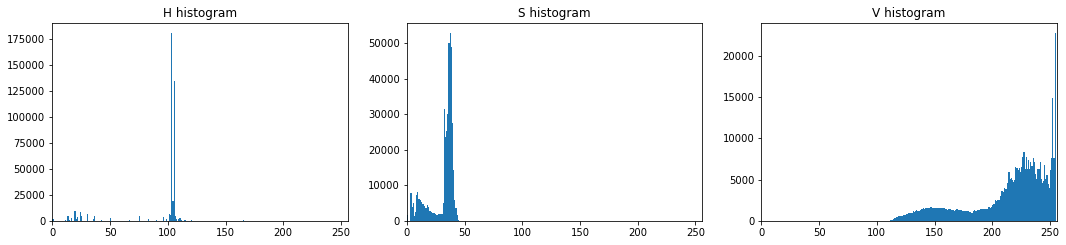

In [7]:
color_bgr = ['h','s','v']
for i,col in enumerate(color_bgr):
    plt.subplot(2, 3, i+1)
    plt.title("{} histogram".format(col.upper()))
    plt.hist(color_lc_image_hsv[:,:,i].ravel(), range=(0,255), label='histogram', bins = np.arange(256))
    plt.xlim([0,256])
plt.show()

Now let's normalize the R, G, B channel histograms separately.

In [8]:
new_image = np.empty(color_lc_image.shape, dtype = np.uint8)
for i in range(3):
    new_image[:, :, i] = equalize_image_histogram(color_lc_image[:, :, i])

What happens if we normalize the three channel histograms separately ? We want to perform histogram equalization to only play on the image contrast without changing its hue and saturation.

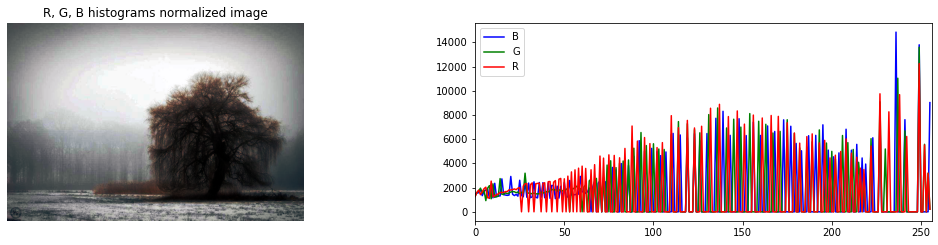

In [9]:
plt.subplot(2, 2, 1)
plt.title('R, G, B histograms normalized image')
plt.imshow(np.flip(new_image, axis=2), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(2, 2, 2)
color_bgr = ['b','g','r']
for i,col in enumerate(color_bgr):
    histr = cv2.calcHist([new_image],[i],None,[256],[0,256])
    plt.plot(histr, color = col, label = col.upper())
    plt.xlim([0,256])
plt.legend()
plt.show()

We can see already that the colors seem to be a bit off. Let us once again visualize the histograms of the H, S and V channels of the resulting image.

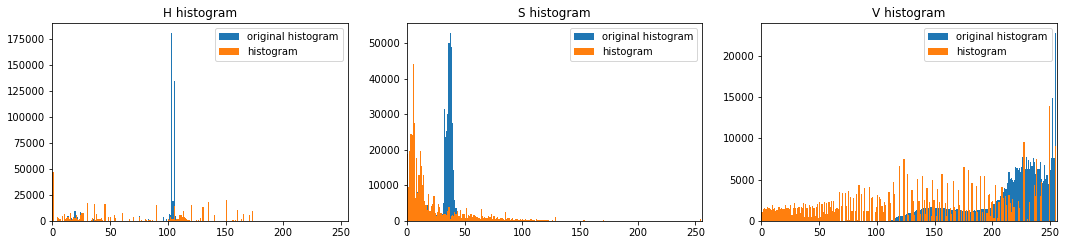

In [10]:
new_image_hsv = cv2.cvtColor(new_image, cv2.COLOR_RGB2HSV)

color_bgr = ['h','s','v']
for i,col in enumerate(color_bgr):
    plt.subplot(2, 3, i+1)
    plt.title("{} histogram".format(col.upper()))
    plt.hist(color_lc_image_hsv[:,:,i].ravel(), range=(0,255), label='original histogram', bins = np.arange(256))
    plt.hist(new_image_hsv[:,:,i].ravel(), range=(0,255), label='histogram', bins = np.arange(256))
    plt.xlim([0,256])
    plt.legend()
plt.show()

We can see that even if the intensity histogram seems equalized, there was a shift in the hue and saturation values. In fact the histogram equalization must be only applied to the intensity map of the image for contrast adjustment. Let us do this correctly now.

In [11]:
new_image_hsv = np.empty(color_lc_image_hsv.shape, dtype = np.uint8)
new_image_hsv[:, :, 0] = color_lc_image_hsv[:, :, 0]
new_image_hsv[:, :, 1] = color_lc_image_hsv[:, :, 1]
new_image_hsv[:, :, 2] = equalize_image_histogram(color_lc_image_hsv[:, :, 2]) # Apply method only here
new_image = cv2.cvtColor(new_image_hsv, cv2.COLOR_HSV2BGR)

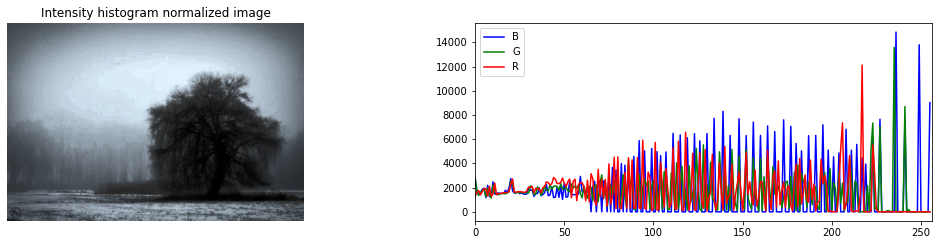

In [12]:
plt.subplot(2, 2, 1)
plt.title('Intensity histogram normalized image')
plt.imshow(np.flip(new_image, axis=2), vmin=0, vmax=255)
plt.axis('off')

plt.subplot(2, 2, 2)
color_bgr = ['b','g','r']
for i,col in enumerate(color_bgr):
    histr = cv2.calcHist([new_image],[i],None,[256],[0,256])
    plt.plot(histr, color = col, label = col.upper())
    plt.xlim([0,256])
plt.legend()
plt.show()

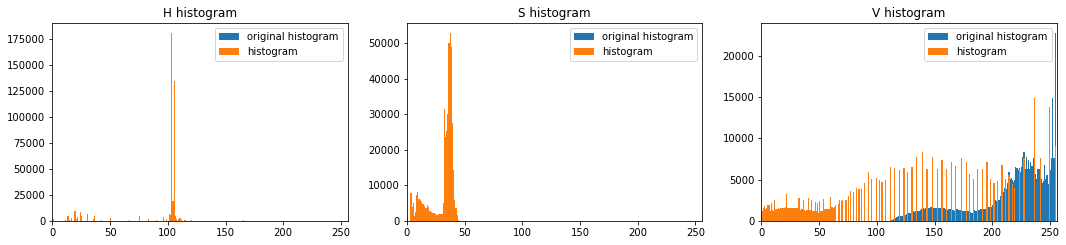

In [13]:
color_bgr = ['h','s','v']
for i,col in enumerate(color_bgr):
    plt.subplot(2, 3, i+1)
    plt.title("{} histogram".format(col.upper()))
    plt.hist(color_lc_image_hsv[:,:,i].ravel(), range=(0,255), label='original histogram', bins = np.arange(256))
    plt.hist(new_image_hsv[:,:,i].ravel(), range=(0,255), label='histogram', bins = np.arange(256))
    plt.xlim([0,256])
    plt.legend()
plt.show()

We can see that the hue and saturation histograms are unchanged now and only the intensity histogram is equalized.

## 3. Adaptive histogram equalization ([source](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html))

The above method takes into account the global intensity of the picture, and we can see that even if the contrast if accentuated, it produces much noise on some areas, some are darkened too much, etc.

We can imagine that an "adaptive" method, i.e. a method which wich considers small locations of the image and performs histogram equalization there, would produce a cleaner result. This would be considered as *adaptive histogram equalization*

However if these small locations contain noise that noise would still be amplified, thus another technique is applied : *contrast limiting* ("To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization."). This is known as the [CLAHE algorithm](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE) (contrast limited adaptive histogram equalization).

Finally there is a final step of interpolation to remove artifacts.

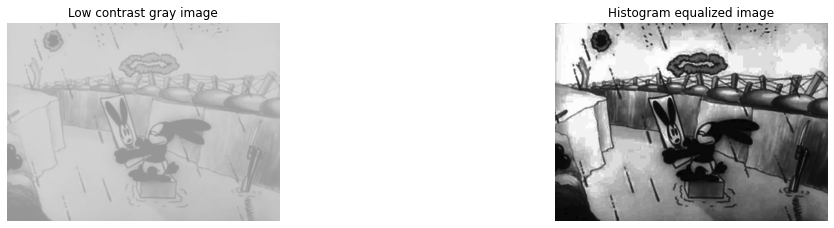

In [14]:
plt.subplot(2, 2, 1)
plt.title('Low contrast gray image')
plt.imshow(gray_lc_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Histogram equalized image')
plt.imshow(gray_eq_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

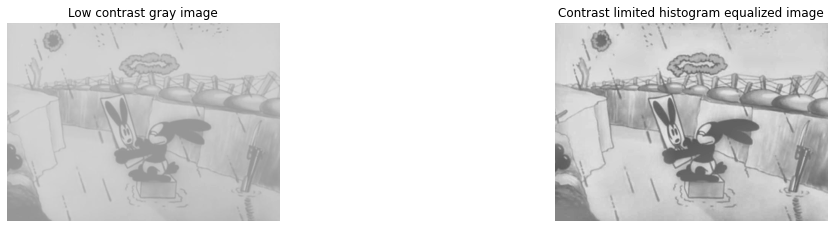

In [15]:
plt.subplot(2, 2, 1)
plt.title('Low contrast gray image')
plt.imshow(gray_lc_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Contrast limited histogram equalized image')
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray_lc_image)
plt.imshow(cl1, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

We can see that the image looks better ! Obviously depending on the input image, the amount of uniformity or noise, various methods will be more or less efficient. For instance the ordinary HE "works well when the distribution of pixel values is similar throughout the image", but when it's not the the case AHE can be more adapted. 

HE and CLAHE are available with the open cv library. There are more variants of HE that are being developed (we saw HE, and briefly AHE and CLAHE): Dynamic Histogram Equalization (DHE), Brightness Preserving Dynamic Histogram Equalization (BPDHE), Dualistic  Sub  Image  Histogram  Equalization  (DSIHE), ...